In [22]:
import glob
from skimage import io
import scipy.io as sio
from skimage import data, io, util
from matplotlib import pyplot as plt
import numpy as np

import cv2
import os
from tqdm import tqdm
import shutil

In [3]:
img_paths = glob.glob("*/*/*/*")

imgs_fold1 = img_paths[2]
labels_fold1 = img_paths[0]

imgs_fold2 = img_paths[8]
labels_fold2 = img_paths[6]

imgs_fold3 = img_paths[5]
labels_fold3 = img_paths[3]

In [2]:
import numpy as np
temp1 = np.load('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke/fold_1/Fold 1/images/fold1/images.npy')
print(temp1.shape)
print(temp1[0].shape)
# temp2 = np.load('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke/fold_2/Fold 2/images/fold2/images.npy')
# print(temp2.shape)
temp3 = np.load('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke/fold_3/Fold 3/images/fold3/images.npy')
print(temp3.shape)

(2656, 256, 256, 3)
(256, 256, 3)
(2722, 256, 256, 3)


In [5]:
2656+2523+2722

7901

In [3]:
print(imgs_fold1, labels_fold1)
print(imgs_fold2, labels_fold2)
print(imgs_fold3, labels_fold3)

Fold 1/images/fold1/images.npy Fold 1/masks/fold1/masks.npy
Fold 2/images/fold2/images.npy Fold 2/masks/fold2/masks.npy
Fold 3/images/fold3/images.npy Fold 3/masks/fold3/masks.npy


In [6]:
def show(img):
  io.imshow(img)
  plt.show()

In [31]:
def create_centroid_mask(centroids, height, width):
    cent_img = np.zeros((height,width))
    cent_img[tuple(centroids.T)] = 1
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    centroids_mask = cv2.dilate(cent_img, kernel, iterations=2)
    
    return centroids_mask

def rescale_sample(sample):
    sample = np.rescale(sample, 2, anti_aliasing=False, multichannel=True)
    return sample

def read_image(imagePath):
    image = io.imread(imagePath)[:,:,:3]
    return image

def read_annotation(annotPath):
    mask = sio.loadmat(annotPath)
    
    centroid_map = create_centroid_mask(mask['centroid'].astype(int)[:,::-1], mask['inst_map'].shape[0], mask['inst_map'].shape[1])
    inst_map = mask['inst_map']
    nuclear_map = inst_map+0
    nuclear_map[nuclear_map!=0] = 1
    
    return centroid_map, inst_map, nuclear_map

def get_inst_centroid(inst_map):
    """Get instance centroids given an input instance map.
    Args:
        inst_map: input instance map
    
    Returns:
        array of centroids
    
    """
    inst_centroid_list = []
    inst_id_list = list(np.unique(inst_map))
    for inst_id in inst_id_list[1:]:  # avoid 0 i.e background
        mask = np.array(inst_map == inst_id, np.uint8)
        inst_moment = cv2.moments(mask)
        inst_centroid = [
            int(inst_moment["m10"] / inst_moment["m00"]),
            int(inst_moment["m01"] / inst_moment["m00"]),
        ]
        inst_centroid_list.append(inst_centroid)
    return np.array(inst_centroid_list)

In [34]:
def process_fold(images, masks, output_dir, fold):
    
    for idx in tqdm(range(images.shape[0]),total=images.shape[0]):

        image = images[idx]
        mask = masks[idx]
        
        try:
            centroids = get_inst_centroid(np.sum(mask[:,:,:5],axis=2))
            centroid_map = create_centroid_mask(centroids[:,::-1], mask.shape[0], mask.shape[1])
            inst_map = np.sum(mask[:,:,:5],axis=2)
            nuclear_map = ((mask[:,:,5]*-1)+1).astype(int)
            type_map = np.argmax(mask[:,:,:5],axis=2)+1
            type_map[type_map==7] = 0
#             return
        except:
            continue
        


        output_mask = np.zeros((image.shape[0],image.shape[1],7))
        output_mask[:,:,:3] = image/255.0
        output_mask[:,:,3] = inst_map # inst_mask
        output_mask[:,:,4] = nuclear_map # binary mask
        output_mask[:,:,5] = centroid_map # centroids_mask
        output_mask[:,:,6] = type_map # type mask


#         show(inst_map)
#         show(nuclear_map)
#         show(centroid_map)

#         print(np.unique(inst_map))
#         print(np.unique(nuclear_map))
#         print(np.unique(centroid_map))

        print(idx)
        np.save("{}/{}_{}.npy".format(output_dir,fold,idx), output_mask)
    

In [26]:
train_dir = "C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke_processed/train"


try:
    shutil.rmtree(train_dir)
except:
    pass

try:
    shutil.rmtree(test_dir)
except:
    pass
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

print("Processing Fold1")
images = np.load('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke/fold_1/Fold 1/images/fold1/images.npy')
masks = np.load('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke/fold_1/Fold 1/masks/fold1/masks.npy')
# process_fold(images, masks, train_dir, "fold1")
process_fold(images, masks, test_dir, "fold1")
# print(masks[0].shape)
# print(len(np.nonzero(masks[0])))
# print(masks[0].shape)
# x=np.nonzero(masks[100])
# # print(x[0])
# print(np.unique(x[1]))
# print(len(x[2]))
# print(np.unique(x[2]))
# print(x)

# print("Processing Fold2")
# images = np.load(imgs_fold2)
# masks = np.load(labels_fold2)
# process_fold(images, masks, train_dir, "fold2")
#
# print("Processing Fold3")
# images = np.load(imgs_fold3)
# masks = np.load(labels_fold3)
# process_fold(images, masks, test_dir, "fold3")



Processing Fold1


100%|██████████| 2656/2656 [00:41<00:00, 64.14it/s] 


In [20]:
t=np.load('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke_processed/train/fold1_100.npy')
print(t.shape)
X=t[...,(0,1,2)]
Y=t[...,3]
cls=t[...,4]


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke_processed/train/fold1_100.npy'

In [11]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    # im = ai.imshow(img, clim=(0,1))
    ai.set_title(img_title)
    fig.colorbar(im, ax=ai)
    # al.imshow(lbl, cmap=lbl_cmap) orig

    al.imshow(lbl)
    al.set_title(lbl_title)
    plt.tight_layout()

(256, 256, 7)
(256, 256, 3)


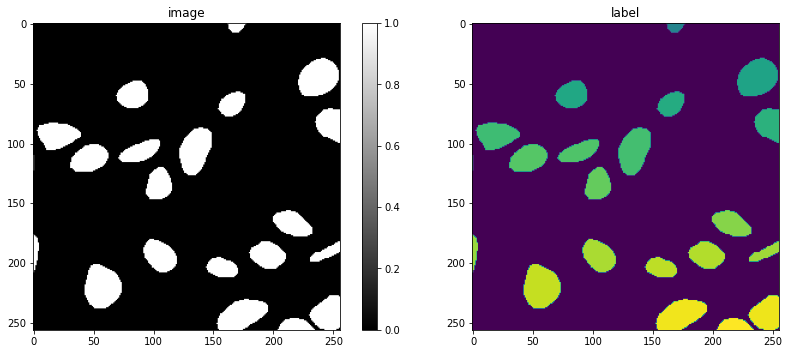

In [33]:
t=np.load('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke_processed/train/fold1_100.npy')
print(t.shape)
X=t[...,(0,1,2)]
Y=t[...,3]
cls=t[...,4]
print(X.shape)

assert X.ndim in (2,3)
X = X if (X.ndim==2 or X.shape[-1]==3) else X[...,0]
plot_img_label(cls,Y)
None;

In [8]:
train_dir = "../../hover/processed/pan2/train"
test_dir = "../../hover/processed/pan2/test"

try:
    shutil.rmtree(train_dir)
except:
    pass

try:
    shutil.rmtree(test_dir)
except:
    pass
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

print("Processing Fold1")
images = np.load(imgs_fold1)
masks = np.load(labels_fold1)
process_fold(images, masks, train_dir, "fold1")

print("Processing Fold2")
images = np.load(imgs_fold2)
masks = np.load(labels_fold2)
process_fold(images, masks, test_dir, "fold2")

print("Processing Fold3")
images = np.load(imgs_fold3)
masks = np.load(labels_fold3)
process_fold(images, masks, train_dir, "fold3")

Processing Fold1


100%|██████████| 2656/2656 [00:48<00:00, 55.15it/s]


Processing Fold2


100%|██████████| 2523/2523 [00:34<00:00, 73.69it/s] 


Processing Fold3


100%|██████████| 2722/2722 [00:38<00:00, 70.69it/s] 


In [ ]:
# train_dir = "../../hover/processed/pan3/train"
# test_dir = "../../hover/processed/pan3/test"
imgs_fold1='C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke/fold_3/Fold 3/images/fold3/images.npy'
labels_fold1='C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke/fold_3/Fold 3/masks/fold3/masks.npy'
out_dir='C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke_fold3/'
try:
    shutil.rmtree(out_dir)
except:
    pass

try:
    shutil.rmtree(test_dir)
except:
    pass
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

print("Processing Fold1")
images = np.load(imgs_fold1)
masks = np.load(labels_fold1)
process_fold(images, masks, out_dir, "fold3")
#
# print("Processing Fold2")
# images = np.load(imgs_fold2)
# masks = np.load(labels_fold2)
# process_fold(images, masks, train_dir, "fold2")
#
# print("Processing Fold3")
# images = np.load(imgs_fold3)
# masks = np.load(labels_fold3)
# process_fold(images, masks, train_dir, "fold3")